In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import sys
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go

# Add the root project directory to the Python path
project_root = Path.cwd().parent  # This will get the project root since the notebook is in 'notebooks/'
sys.path.append(str(project_root))
from configs.path_config import EXTRACTED_DATA_DIR, OUTPUT_DIR

from src.clustering import clustering_preprocess #load_data, drop_columns_by_header_rules, remove_outliers, explain_variance, do_pca
from src.clustering import clustering_models # kmeans_clustering, gmm_clustering, kl_divergence, jeffreys_divergence, merge_clusters_by_divergence, streaming_dpgmm_clustering
from src.clustering import clustering_visualization #plot_clusters_over_time, plot_cluster_mean_and_std

C:\Users\gwd007\Documents\Exjobb


### Data loading and preprocessing


In [2]:
path = EXTRACTED_DATA_DIR / 'strain_distributions' / 'alvbrodel_04' / 'S-E_Close_Comp_20091129120000_20210611160000_strain_distribution_04.csv'
# path = OUTPUT_DIR / 'strain_distributions' / 'N-F_Mid_Comp_20091129120000_20210611160000_strain_distribution.csv'
df = clustering_preprocess.load_data(path)
# df

In [3]:
df = clustering_preprocess.drop_columns_by_header_rules(df, threshold=0)
# df

In [4]:
df_strain, df = clustering_preprocess.remove_outliers(df, threshold=7, individual_threshold=7)
# df

Total number of outliers removed: 240


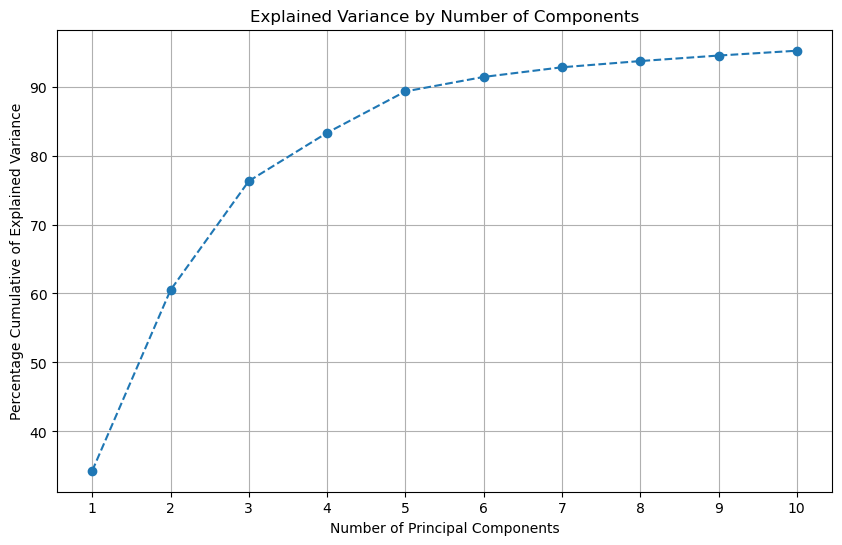

In [5]:
clustering_preprocess.explain_variance(df_strain)

In [6]:
n_components = 8
normalized_pca_components, df_pca = clustering_preprocess.do_pca(n_components, df_strain, df)

### GMM Clustering

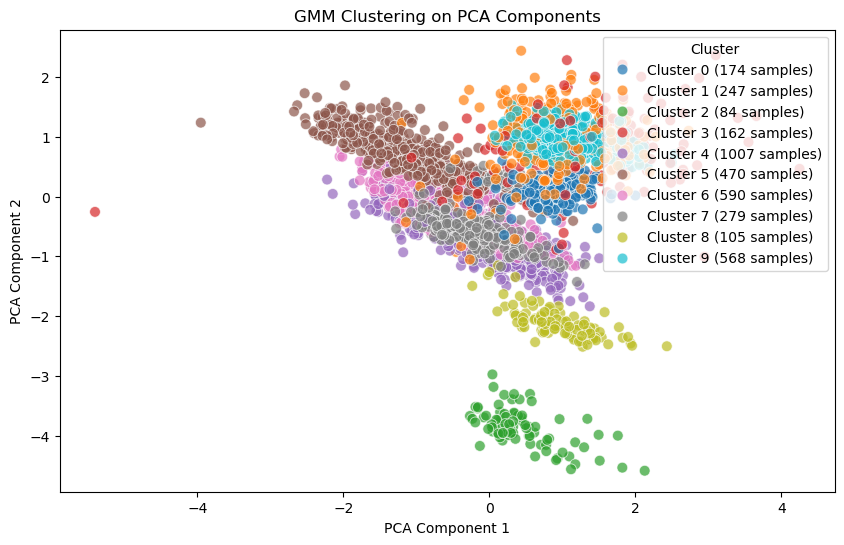

In [7]:
n_clusters = 10
data_with_gmm, cluster_color_map  = clustering_models.gmm_clustering(normalized_pca_components, df, n_clusters)
# data_with_gmm

In [8]:
clustering_visualization.plot_clusters_over_time(data_with_gmm, cluster_color_map, 'GMM')

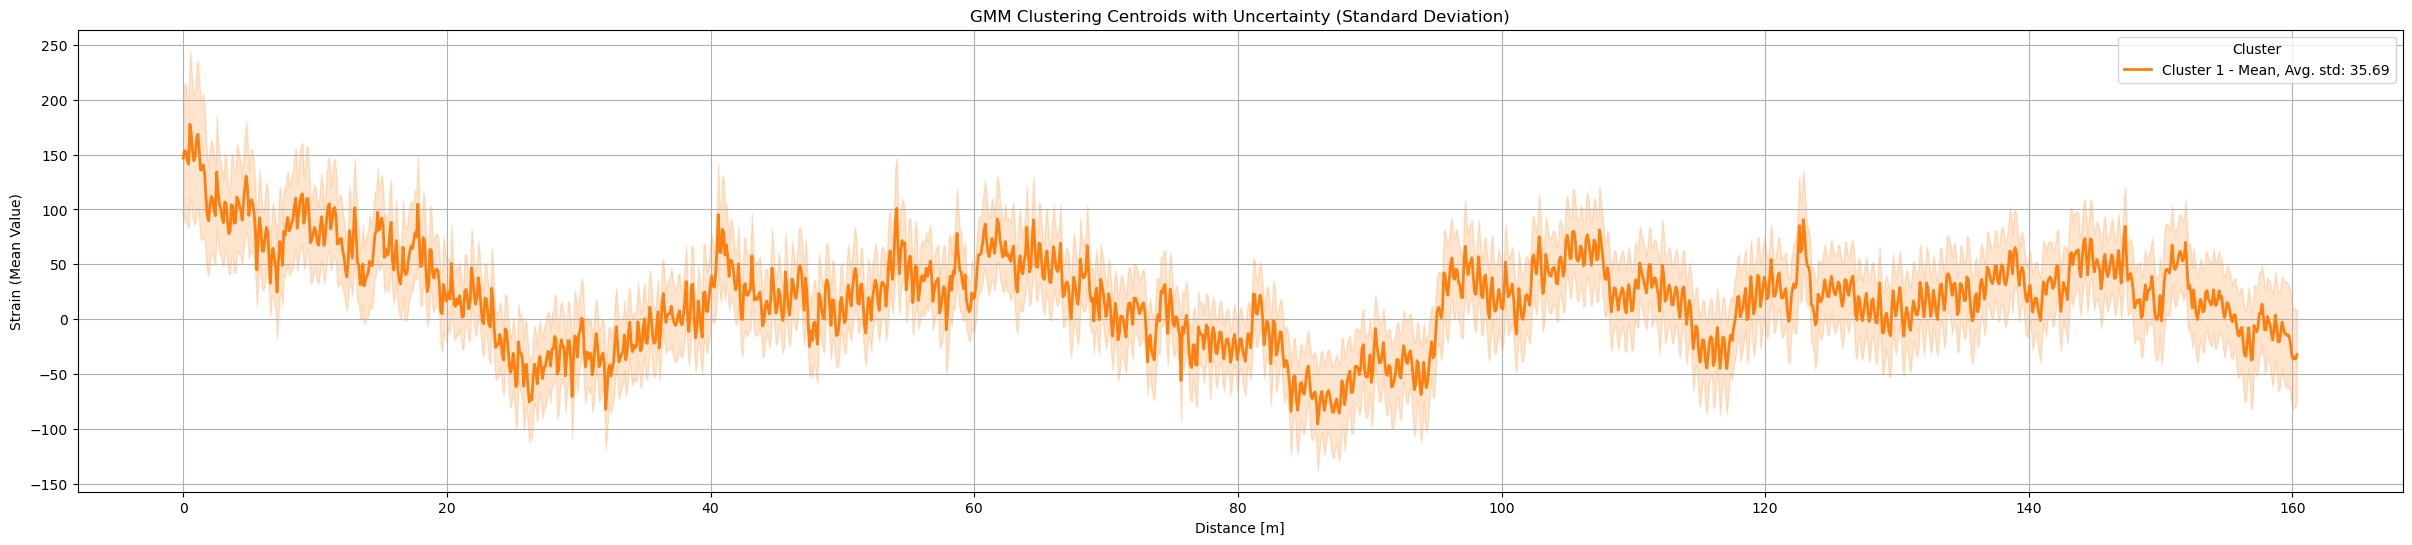

In [9]:
clusters_to_keep = [1] # 'all' or a list of cluster indices
clustering_visualization.plot_cluster_mean_and_std(data_with_gmm, clusters_to_keep, cluster_color_map, 'GMM')

### DPGMM Clustering

In [10]:
data_with_dpgmm, cluster_color_map = clustering_models.streaming_dpgmm_clustering(
    normalized_pca_components=normalized_pca_components,
    df=df,
    prior=0.1,                  # Decides how restrictive the moodel is when creating new clusters the lower the more restrictive
    n_points=1000,            # Number of points to use for the initial clustering
    window_size=400,          # Size of the sliding window
    step_size=100,             # Step size for the sliding window
    max_components=100,       # Maximum number of components to use in the model
    merge_threshold=30,       # Threshold for merging clusters
    merge_within_window=True  # Toggle ON/OFF
)

c:\Users\gwd007\AppData\Local\anaconda3\envs\exjobb\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.



Initial fit => Clusters used: 7


TypeError: 'BayesianGaussianMixture' object is not subscriptable

In [ ]:
clustering_visualization.plot_clusters_over_time(data_with_dpgmm, cluster_color_map, 'DPGMM')

In [ ]:
df_cluster = data_with_dpgmm[data_with_dpgmm['Cluster'] == 1]
df_cluster

Timestamp  Cluster  Assigned_Cluster_Prob  0.0  0.1  \
448  2011-02-27 04:00:00        1           3.528450e-47  -30  -28   
504  2011-04-28 04:00:00        1           1.542179e-32   11   21   
590  2011-09-01 04:00:00        1          5.202854e-106  -23  -11   
635  2011-10-16 04:00:00        1           1.927398e-28   16   24   
1136 2013-07-14 04:00:00        1           2.532716e-20  -54  -44   
...                  ...      ...                    ...  ...  ...   
3687 2020-10-06 04:00:00        1           2.893193e-19   77   83   
3723 2020-11-11 04:00:00        1           4.032719e-22   59   62   
3728 2020-11-16 04:00:00        1           4.061684e-34  134  138   
3735 2020-11-23 04:00:00        1           7.012557e-31  104  106   
3753 2020-12-11 04:00:00        1           1.367608e-27  116  116   

      0.19999999999999998  0.30000000000000004  0.41000000000000003  0.51  \
448                   -28                  -25                  -24   -23   
504                    28                   32                   33    31   
590                    -2                    3                    5     3   
635                    32                   37                   38    35   
1136                  -33                  -30                  -40   -54   
...                   ...                  ...                  ...   ...   
3687                   90                   72                   58    81   
3723                   66                   51                   42    67   
3728                  142                  128                  118   143   
3735                  109                   95                   87   113   
3753                  116                  106                  102   127   

      0.61  ...  159.42  159.51999999999998  159.62  159.72  159.82  159.93  \
448    -25  ...      24                  32      28      23      26      21   
504     26  ...      23                  28      17      13      19      14   
590     -2  ...      10                  19      14      14      18      13   
635     29  ...      18                  21      14      11      21      13   
1136   -64  ...     122                 126     115      99      92      76   
...    ...  ...     ...                 ...     ...     ...     ...     ...   
3687    81  ...     -66                 -66     -64     -62     -65     -68   
3723    71  ...     -71                 -74     -78     -80     -78     -78   
3728   146  ...    -106                -108    -111    -109    -106    -106   
3735   117  ...     -93                 -95     -97     -97     -93     -93   
3753   126  ...      -9                  -6      -4      -9     -17     -26   

      160.02999999999997  160.13  160.23  160.32999999999998  
448                   21      10       2                   8  
504                   14       7      -2                   5  
590                   10       6       1                  10  
635                   10       8       0                   7  
1136                  63      46      34                  45  
...                  ...     ...     ...                 ...  
3687                 -71     -68     -69                 -68  
3723                 -80     -76     -72                 -66  
3728                -110    -109    -107                 -97  
3735                 -95     -92     -91                 -87  
3753                 -42     -53     -60                 -57  

[777 rows x 1580 columns]

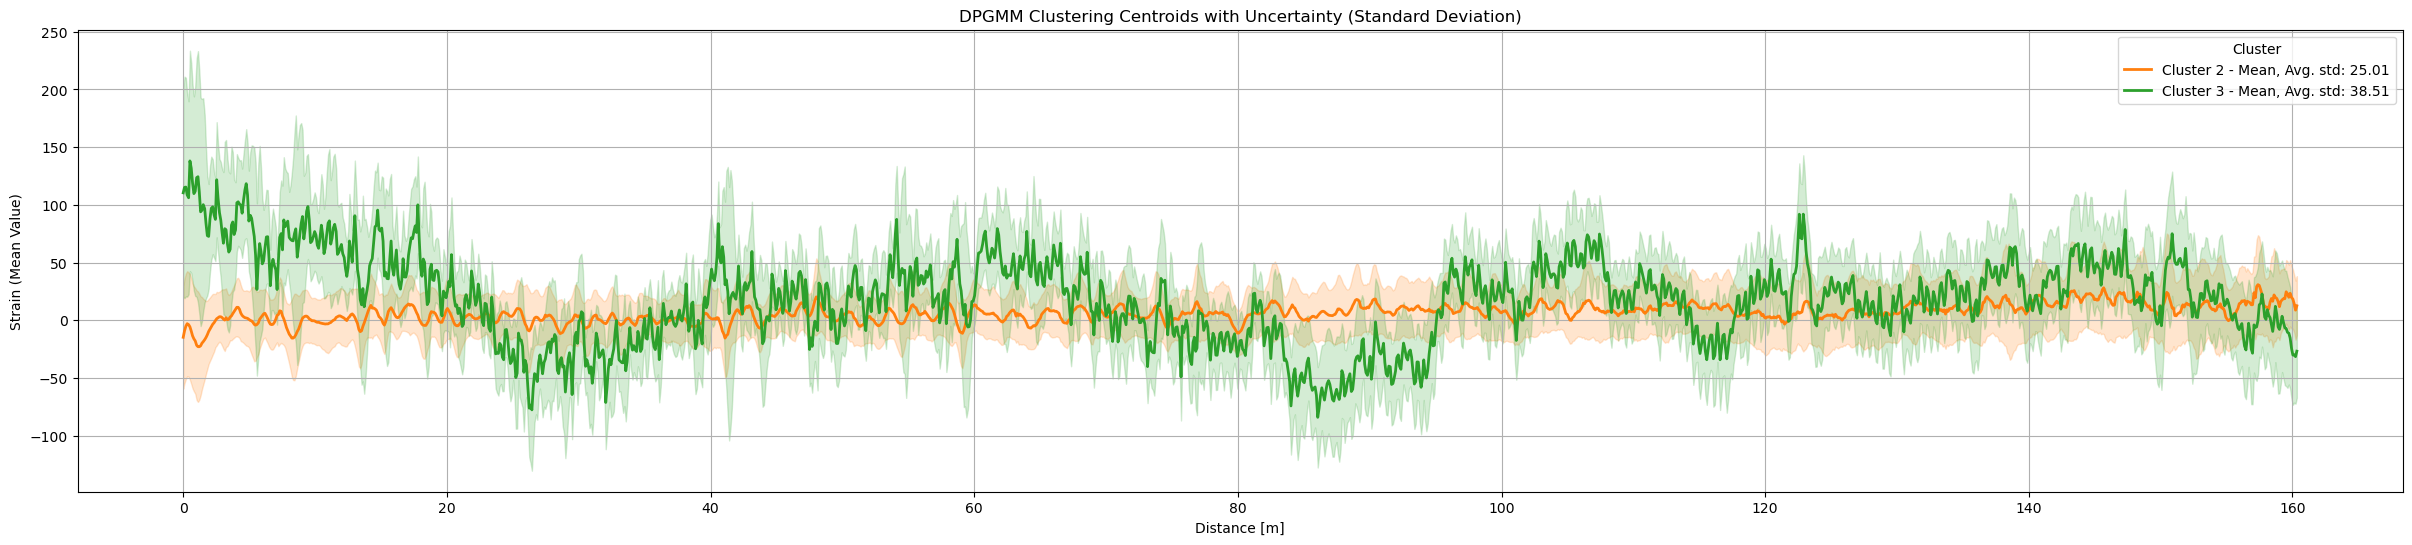

In [ ]:
clusters_to_keep = [2, 3] # 'all' or a list of cluster indices
clustering_visualization.plot_cluster_mean_and_std(data_with_dpgmm, clusters_to_keep, cluster_color_map, 'DPGMM')